In [1]:
%load_ext autoreload
%autoreload 2

In [66]:
import meerkat as mk
import pandas as pd
import torch
mk.config.DisplayOptions.max_rows = 100

In [3]:
dp = mk.datasets.get(
    "celeba", 
    dataset_dir="/home/common/datasets/celeba",
    download=False
)

In [4]:
dp.data.reorder(["image"] + dp.columns[:-1])



,image (ImageColumn),file (PandasSeriesColumn),identity (PandasSeriesColumn),5_o_clock_shadow (PandasSeriesColumn),arched_eyebrows (PandasSeriesColumn),attractive (PandasSeriesColumn),bags_under_eyes (PandasSeriesColumn),bald (PandasSeriesColumn),bangs (PandasSeriesColumn),big_lips (PandasSeriesColumn),big_nose (PandasSeriesColumn),black_hair (PandasSeriesColumn),blond_hair (PandasSeriesColumn),blurry (PandasSeriesColumn),brown_hair (PandasSeriesColumn),bushy_eyebrows (PandasSeriesColumn),chubby (PandasSeriesColumn),double_chin (PandasSeriesColumn),eyeglasses (PandasSeriesColumn),goatee (PandasSeriesColumn),gray_hair (PandasSeriesColumn),heavy_makeup (PandasSeriesColumn),high_cheekbones (PandasSeriesColumn),male (PandasSeriesColumn),mouth_slightly_open (PandasSeriesColumn),mustache (PandasSeriesColumn),narrow_eyes (PandasSeriesColumn),no_beard (PandasSeriesColumn),oval_face (PandasSeriesColumn),pale_skin (PandasSeriesColumn),pointy_nose (PandasSeriesColumn),receding_hairline (PandasSeriesColumn),rosy_cheeks (PandasSeriesColumn),sideburns (PandasSeriesColumn),smiling (PandasSeriesColumn),straight_hair (PandasSeriesColumn),wavy_hair (PandasSeriesColumn),wearing_earrings (PandasSeriesColumn),wearing_hat (PandasSeriesColumn),wearing_lipstick (PandasSeriesColumn),wearing_necklace (PandasSeriesColumn),wearing_necktie (PandasSeriesColumn),young (PandasSeriesColumn),img_path (PandasSeriesColumn),image_id (PandasSeriesColumn),split (PandasSeriesColumn)
0,,000001.jpg,2880,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1,img_align_celeba/000001.jpg,000001.jpg,train
1,,000002.jpg,2937,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,img_align_celeba/000002.jpg,000002.jpg,train
2,,000003.jpg,8692,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,img_align_celeba/000003.jpg,000003.jpg,train
3,,000004.jpg,5805,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1,img_align_celeba/000004.jpg,000004.jpg,train
4,,000005.jpg,9295,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,img_align_celeba/000005.jpg,000005.jpg,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,,000016.jpg,4905,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,img_align_celeba/000016.jpg,000016.jpg,train
16,,000017.jpg,667,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,img_align_celeba/000017.jpg,000017.jpg,train
17,,000018.jpg,2464,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,0,0,1,0,1,0,1,0,1,1,0,1,1,0,0,img_align_celeba/000018.jpg,000018.jpg,train
18,,000019.jpg,2929,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,1,1,0,1,img_align_celeba/000019.jpg,000019.jpg,train

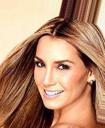
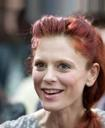
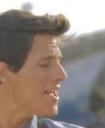
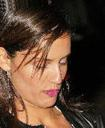
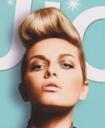
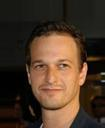
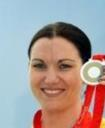
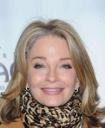
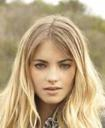
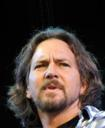

In [5]:
dp.head(20)

In [24]:
from domino.eval.utils import induce_correlation

idxs = induce_correlation(
    dp=dp,
    corr=0.8,
    n=30_000,
    attr_a="eyeglasses",
    attr_b="wearing_necktie"
)
corr_dp = dp.lz[idxs]

In [26]:
from domino.eval.train import train

In [39]:
corr_dp["split"] = ["train" if 

train    24132
test      2974
valid     2891
Name: col, dtype: int64

In [67]:
corr_dp["split"] = pd.Series(np.random.choice(["train", "valid"], len(corr_dp), p=[0.6, 0.4]))

In [116]:
model = train(
    dp=corr_dp,
    input_column="image",
    target_column="wearing_necktie",
    config={"pretrained": False},
    id_column="file",
    batch_size=128,
    max_epochs=5
)

[2022-01-25 00:16:24,178][INFO][pytorch_lightning.utilities.seed:69] :: Global seed set to 123
/home/common/envs/conda/envs/domino-release/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
[2022-01-25 00:16:24,365][INFO][pytorch_lightning.utilities.distributed:1570] :: GPU available: True, used: True
[2022-01-25 00:16:24,366][INFO][pytorch_lightning.utilities.distributed:1573] :: TPU available: False, using: 0 TPU cores
[2022-01-25 00:16:24,367][INFO][pytorch_lightning.utilities.distributed:1576] :: IPU available: False, using: 0 IPUs
[2022-01-25 00:16:24,397][INFO][pytorch_lightning.accelerators.gpu:59] :: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[2022-01-25 00:16:24,528][INFO][pytorch_lightning.callbacks.model_summary:73] :: 
  | Name    | Type       | Params
---------------------------------------
0 

Validation sanity check: 0it [00:00, ?it/s]

/home/common/envs/conda/envs/domino-release/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:453: UserWarning: Your `val_dataloader` has `shuffle=True`,it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
[2022-01-25 00:16:26,174][INFO][pytorch_lightning.utilities.seed:69] :: Global seed set to 123


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [139]:
corr_dp["input"] = corr_dp["image"].to_lambda(model.config["transform"])
model.to(0)
@torch.autograd.no_grad()
def forward(batch):
    return torch.softmax(model(batch.data.to(0)), dim=1).cpu().numpy()

corr_dp["probs"] = corr_dp["input"].map(
    forward, 
    is_batched_fn=True, 
    batch_size=128, 
    pbar=True,
    num_workers=6
)

  0%|          | 0/235 [00:00<?, ?it/s]

In [140]:
valid_dp = corr_dp.lz[corr_dp["split"] == "valid"]

In [141]:
from sklearn.metrics import roc_auc_score

roc_auc_score(valid_dp["wearing_necktie"].data, valid_dp["preds"].data[:, 1])

0.9540943544281387

In [153]:
pos_dp = valid_dp.lz[valid_dp["wearing_necktie"] != 1]
print(f'Overall Specificity:{(pos_dp["probs"][:, 0] > 0.5).mean()}')
print(f'In-slice Specificity:{(pos_dp.lz[pos_dp["eyeglasses"] == 1]["probs"][:, 1] > 0.5).mean()}')

Overall Specificity:0.9912675549153763
In-slice Specificity:0.5192307692307693


In [79]:
CELEBA_PHRASE_TEMPLATES = [
    "a photo of a person {} [MASK].",
    "a photo of a person [MASK] {}.",
    "a photo of a person [MASK] {} [MASK].",
    "a photo of a person [MASK] [MASK] {}.",
    "a photo of [MASK] {} person",
    "[MASK] {} photo of a person",
]

from domino.emb.clip import generate_phrases, get_wiki_words, embed_text

words_dp = get_wiki_words(eng_only=True)

text_dp = generate_phrases(
    words_dp=words_dp[:10000],
    templates=CELEBA_PHRASE_TEMPLATES
)

text_dp = embed_text(text_dp)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/625 [00:00<?, ?it/s]

In [80]:
from domino.emb.clip import embed_text

text_dp = embed_text(text_dp)

  0%|          | 0/235 [00:00<?, ?it/s]

In [120]:
from domino.emb.clip import embed_images

valid_dp = embed_images(valid_dp)

  0%|          | 0/94 [00:00<?, ?it/s]

In [121]:
valid_dp["target"] = (valid_dp["wearing_necktie"] == 1)

In [122]:
valid_dp["probs"] = torch.softmax(torch.tensor(valid_dp["preds"].data), dim=-1)

In [125]:
from domino import DominoSDM


domino = DominoSDM(
    y_log_likelihood_weight=20,
    y_hat_log_likelihood_weight=20,
    n_mixture_components=30,
    n_slices=10,
    max_iter=10,
    n_pca_components=128,
    init_params="confusion",
    confusion_noise=3e-3
)

domino.fit(data=valid_dp, embeddings="emb", targets="target", pred_probs="probs")
valid_dp["domino_slices"] = domino.transform(
    data=valid_dp, embeddings="emb", targets="target", pred_probs="probs"
)

18.7848715740029


  0%|          | 0/10 [00:00<?, ?it/s]

/pd/sabri/code/domino/domino/domino.py:481: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


In [133]:
slice_dp = valid_dp.lz[(-valid_dp["domino_slices"].data[:, 5]).argsort()]
slice_dp["target_slice"] = ~slice_dp["wearing_necktie"] & slice_dp["eyeglasses"]
slice_dp.lz[:10]["target_slice"].mean()

1.0

In [138]:
slice_dp = valid_dp.lz[valid_dp["domino_slices"].data[:, 5] > 0.99]
slice_dp["target_slice"] = ~slice_dp["wearing_necktie"] & slice_dp["eyeglasses"]
slice_dp["target_slice"].mean()

0.8709677419354839

In [126]:
from domino import explore

explore(
    data=valid_dp,
    embedding_column="emb",
    pred_prob_column="probs",
    target_column="target",
    slice_column="domino_slices",
    text=text_dp,
    text_embeddings="emb",
)

Output()